<a href="https://colab.research.google.com/github/gen95mis/dataset/blob/main/image_segmentation_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


![UNet model](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

[Source](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)

# Downloading dataset Cityscape

[Cityscapes Image Pairs](https://www.kaggle.com/dansbecker/cityscapes-image-pairs)

In [143]:
import os
if os.path.isdir('./images') == False:
  !wget https://github.com/gen95mis/dataset/raw/main/images-1.zip?raw=true -O images-1.zip
  !wget https://github.com/gen95mis/dataset/raw/main/images-2.zip?raw=true -O images-2.zip
  !wget https://github.com/gen95mis/dataset/raw/main/labels.zip -O labels.zip
  
  !unzip images-1.zip
  !unzip images-2.zip
  !unzip labels.zip

  !rm images-1.zip
  !rm images-2.zip
  !rm labels.zip

  !mkdir images
  !cp -R images-1/* images
  !cp -R images-2/* images

  !rm -rf images-1
  !rm -rf images-2

# 1. Import packages

In [144]:
import tensorflow as tf
import os
import random
import numpy as np
 
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split

# 2. The lables mark

In [145]:
from collections import namedtuple

Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'color'       , # The color of this label
  ] 
)

labels = [
  #       name                     id           color
  Label(  'Void'                  ,  0  ,        np.array([0,0,0]) ),
  Label(  'Car'                   ,  1  ,        np.array([0,0,255]) ), 
  Label(  'Road'                  ,  2  ,        np.array([255,0,0]) ), 
  Label(  'Mark'                  ,  3  ,        np.array([255,255,0]) ), 
  Label(  'Building'              ,  4  ,        np.array([0,255,0]) ), 
  Label(  'Sidewalk'              ,  5  ,        np.array([255,0,255]) ), 
  Label(  'Tree/Bush'             ,  6  ,        np.array([0,255,255]) ), 
  Label(  'Pole'                  ,  7  ,        np.array([255,0,153]) ), 
  Label(  'Sign'                  ,  8  ,        np.array([153,0,255]) ), 
  Label(  'Person'                ,  9  ,        np.array([0,153,255]) ),
  Label(  'Wall'                  , 10  ,        np.array([153,255, 0]) ),
  Label(  'Sky'                   , 11  ,        np.array([255,153, 0]) ),
  Label(  'Curb'                  , 12  ,        np.array([0,255,153]) ),
  Label(  'Grass/Dirt'            , 13  ,        np.array([0,153,153]) ),
  Label(  'Side rail'             , 14 ,         np.array([153,153,153]) ),
  Label(  'Object'                , 15  ,        np.array([0, 0,153]) ),
  Label(  'Bicycle/Motorbike'     , 16  ,        np.array([255,255,153]) ),
]

# Initialization

In [146]:
num_images =  100#@param {type: "number" }

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

image_dir = 'images'
image_filenames = os.listdir( image_dir )

labels_dir = 'labels'
labels_filenames = os.listdir( labels_dir )

Done!


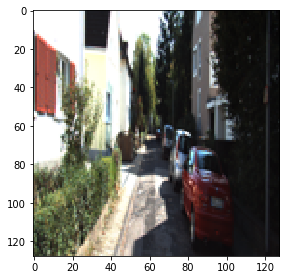

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


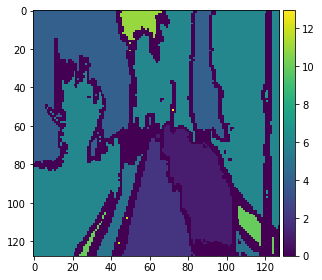

In [147]:
images = np.zeros((num_images,  IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
lables = np.zeros((num_images,  IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)

index = 0
for filename in image_filenames[ 0 : num_images ]:
  image = Image.open(os.path.join(image_dir, filename))
  img = np.asarray(image.resize((IMG_HEIGHT, IMG_WIDTH)))
  images[index] = img
  index += 1
 
index = 0
for filename in labels_filenames[ 0 : num_images ]:
  label = Image.open(os.path.join(labels_dir, filename))
  img = np.asarray(label.resize((IMG_HEIGHT, IMG_WIDTH)))
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
  for h in range(IMG_HEIGHT):
    for w in range(IMG_WIDTH):
      for l in labels:
        if np.array_equal(l.color, img[h, w]):
          mask[h, w] = np.array([ l.id ],  np.uint8)
  
  lables[index] = mask
  index += 1

print('Done!')

imshow(images[0])
plt.show()
imshow(np.squeeze(lables[0]))
plt.show()


In [148]:
#@markdown > Процент проверочных изображений
test_size =  0.2#@param {type: "number" }
X_Train, X_Test, Y_Train, Y_Test = train_test_split(images, lables, test_size=test_size)

print(Y_Train.shape)

(80, 128, 128, 1)


# Model

In [175]:
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='relu')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_14 (Lambda)             (None, 128, 128, 3)  0           ['input_15[0][0]']               
                                                                                                  
 conv2d_266 (Conv2D)            (None, 128, 128, 16  448         ['lambda_14[0][0]']              
                                )                                                                 
                                                                                           

In [176]:
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(X_Train, Y_Train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)

Epoch 1/25
5/5 [==============================] - 14s 3s/step - loss: 21.2466 - accuracy: 0.1259 - val_loss: 17.3985 - val_accuracy: 0.0339
Epoch 2/25
5/5 [==============================] - 12s 2s/step - loss: 16.8210 - accuracy: 0.0607 - val_loss: 19.0730 - val_accuracy: 0.0318
Epoch 3/25
5/5 [==============================] - 12s 2s/step - loss: 15.9837 - accuracy: 0.0598 - val_loss: 18.0731 - val_accuracy: 0.0334


In [177]:
idx = random.randint(0, len(X_Train))

In [178]:
preds_train = model.predict(X_Train[:int(X_Train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_Train[int(X_Train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_Test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

1/1 [==============================] - 1s 742ms/step


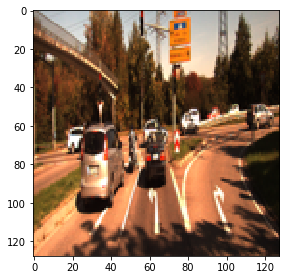

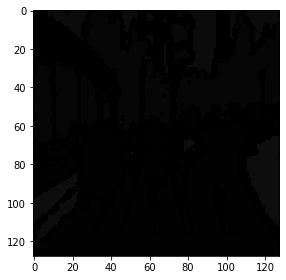

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


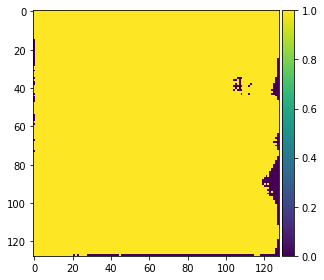

In [179]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_Train[ix])
plt.show()
imshow(np.squeeze(Y_Train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

In [181]:
print(preds_train_t[ix])

[[[1]
  [1]
  [1]
  ...
  [0]
  [0]
  [0]]

 [[1]
  [1]
  [1]
  ...
  [0]
  [0]
  [0]]

 [[1]
  [1]
  [1]
  ...
  [0]
  [0]
  [0]]

 ...

 [[1]
  [1]
  [1]
  ...
  [1]
  [1]
  [0]]

 [[1]
  [1]
  [1]
  ...
  [1]
  [1]
  [0]]

 [[0]
  [1]
  [1]
  ...
  [0]
  [0]
  [0]]]


In [180]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_Train[int(X_Train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_Train[int(Y_Train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

IndexError: ignored